In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape, test_df.shape

((159571, 8), (153164, 2))

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
# Subsetting labels from the training data
train_labels = train_df[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

In [7]:
label_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [13]:
import re 
import string
import nltk
import contractions
from wordcloud import WordCloud

## EDA

In [10]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

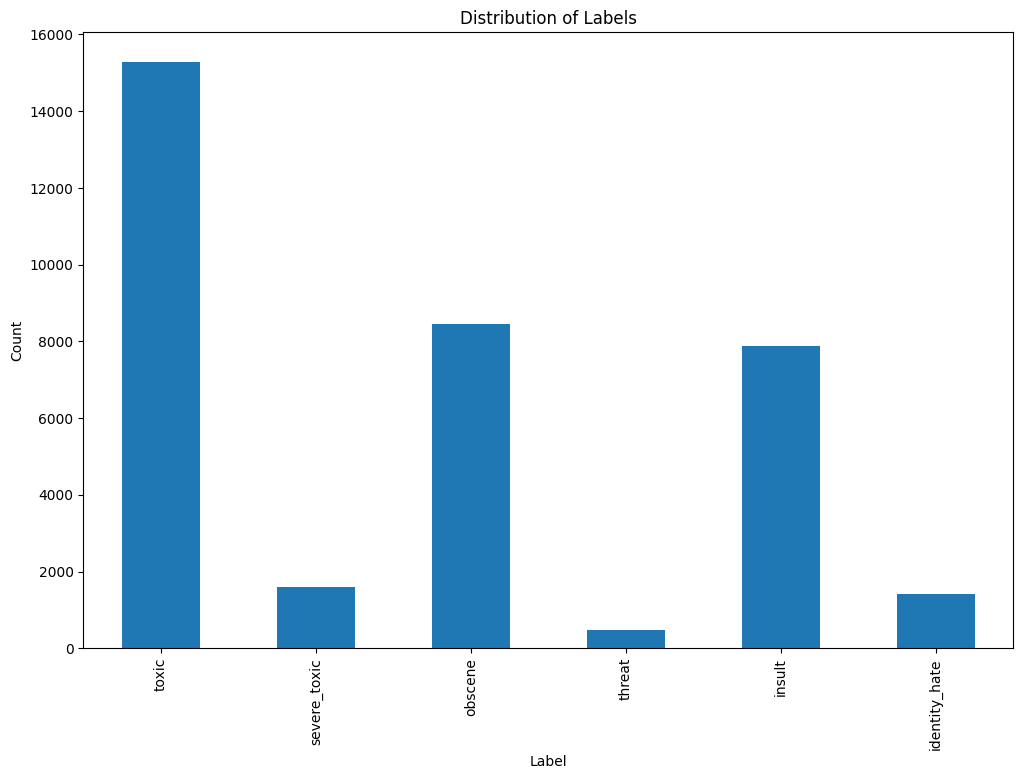

In [12]:
plt.figure(figsize=(12, 8))
train_df[label_columns].sum().plot(kind='bar')
plt.title('Distribution of Labels')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

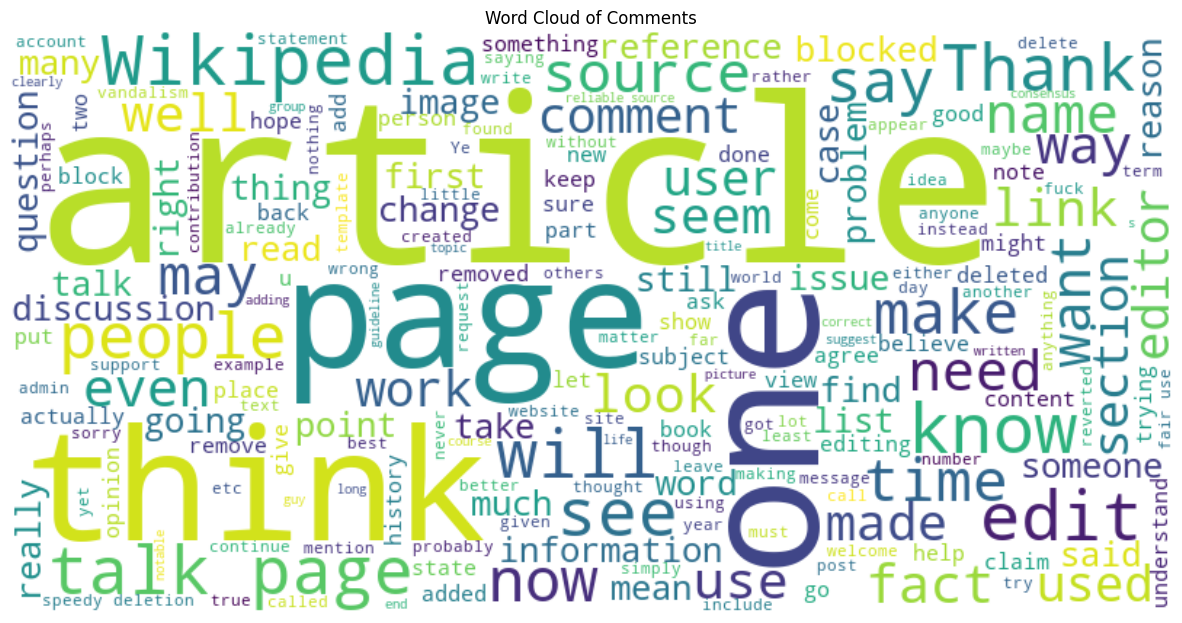

In [14]:
# Word Cloud for the entire dataset
text = ' '.join(train_df['comment_text'].astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

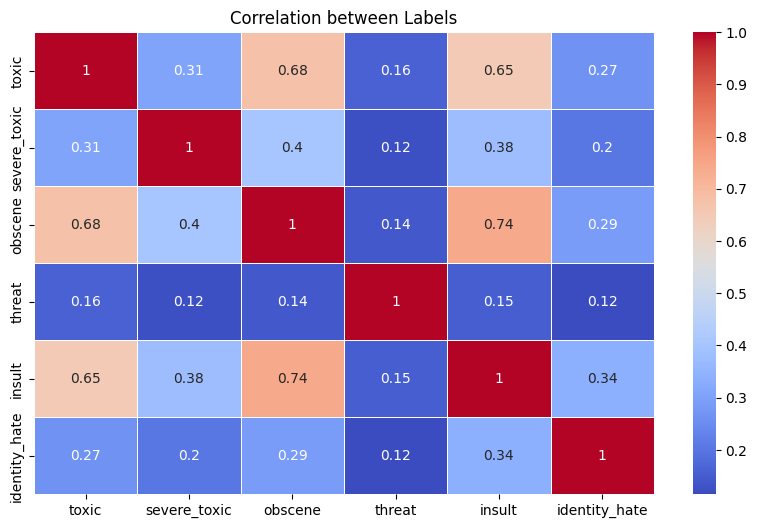

In [15]:
# Correlation between labels
plt.figure(figsize=(10, 6))
correlation_matrix = train_df[label_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Labels')
plt.show()

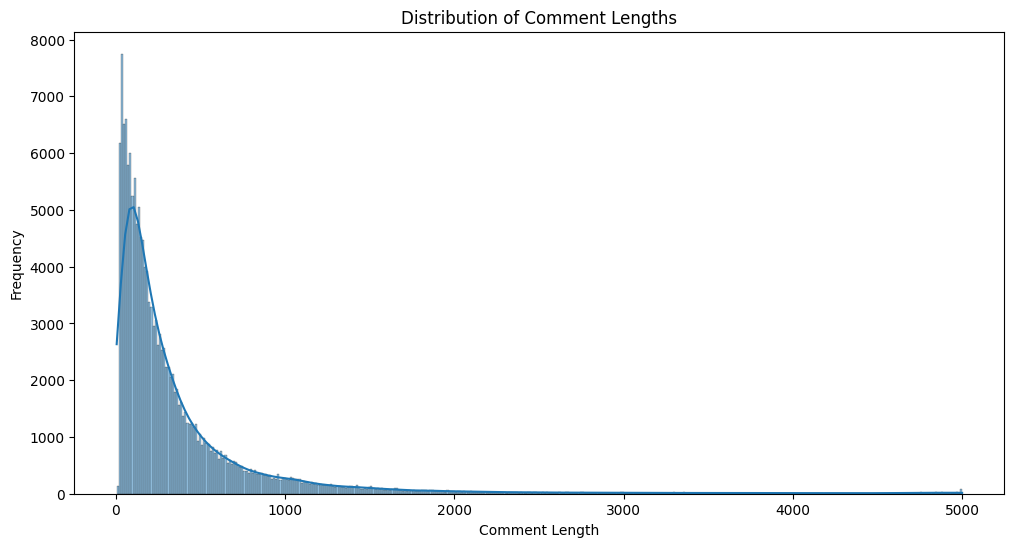

In [16]:
# Length of comments analysis
train_df['comment_length'] = train_df['comment_text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(train_df['comment_length'], kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

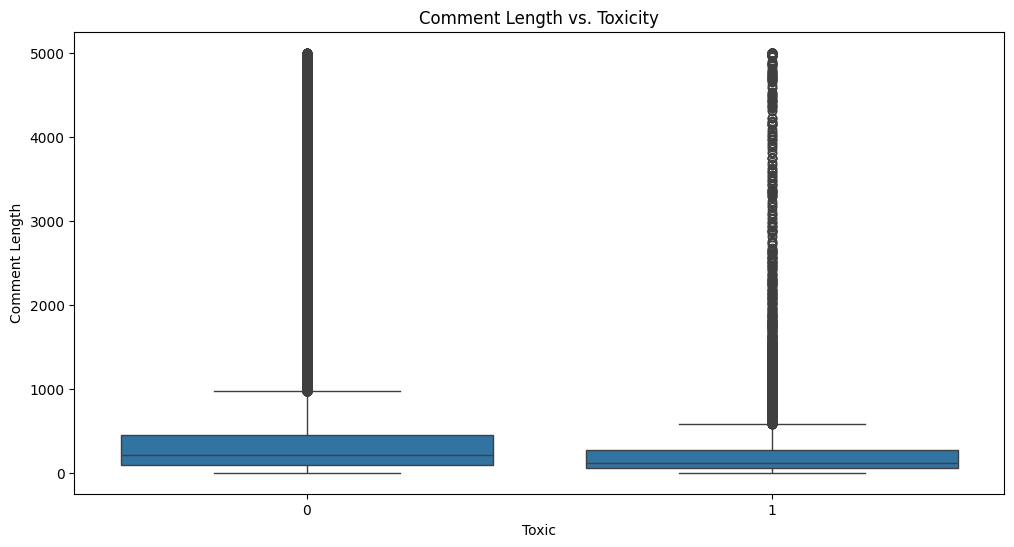

In [18]:
# Relationship between comment length and labels
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='toxic', y='comment_length')
plt.title('Comment Length vs. Toxicity')
plt.xlabel('Toxic')
plt.ylabel('Comment Length')
plt.show()

## Data Preprocessing

In [10]:
def clean_and_preprocess_text(text):
    '''
    Takes a text, cleans it and preprocesses it
    '''
    # Lowercase the text
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r"https?://S+www.\.\S+", "", text)
    
    # Remove HTML tags
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    text = re.sub(html, "", text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

train_df['text_clean'] = train_df['comment_text'].apply(lambda x: clean_and_preprocess_text(x))

## Text before and after the data cleaning

In [11]:
print(train_df['comment_text'][1])
print(train_df['text_clean'][1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
daww he matches this background colour i am seemingly stuck with thanks  talk 2151 january 11 2016 utc


## Importing data preprocessing Libraries

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text_clean'], train_labels, test_size= 0.3)

## Vectorization of the training file

In [14]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32) # Initialize the Tensorflow Vectorizer 


In [15]:
# Word ngram vector
tr_vect = vect_word.fit_transform(X_train)
ts_vect = vect_word.transform(X_test)

ts_vect_array = ts_vect.toarray()
tr_vect_array = tr_vect.toarray()
tr_vect_array = tr_vect_array.reshape(tr_vect_array.shape[0], 1, tr_vect_array.shape[1])
ts_vect_array = ts_vect_array.reshape(ts_vect_array.shape[0], 1, ts_vect_array.shape[1])


In [16]:
import pickle
with open("trained_vectorizer.pkl", "wb") as f:
    pickle.dump(vect_word, f)

In [17]:
ts_vect_array.shape

(47872, 1, 20000)

In [18]:
input_shape = tr_vect_array.shape[1:]
input_shape

(1, 20000)